In [ ]:
import ast
import time
import math
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from math import pi, sqrt
from numpy import arccos, arctan2
from qiskit.visualization.bloch import Bloch
from qiskit import transpile
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_bloch_vector
from qiskit.circuit.library import RYGate, XGate
from qiskit_aer import Aer


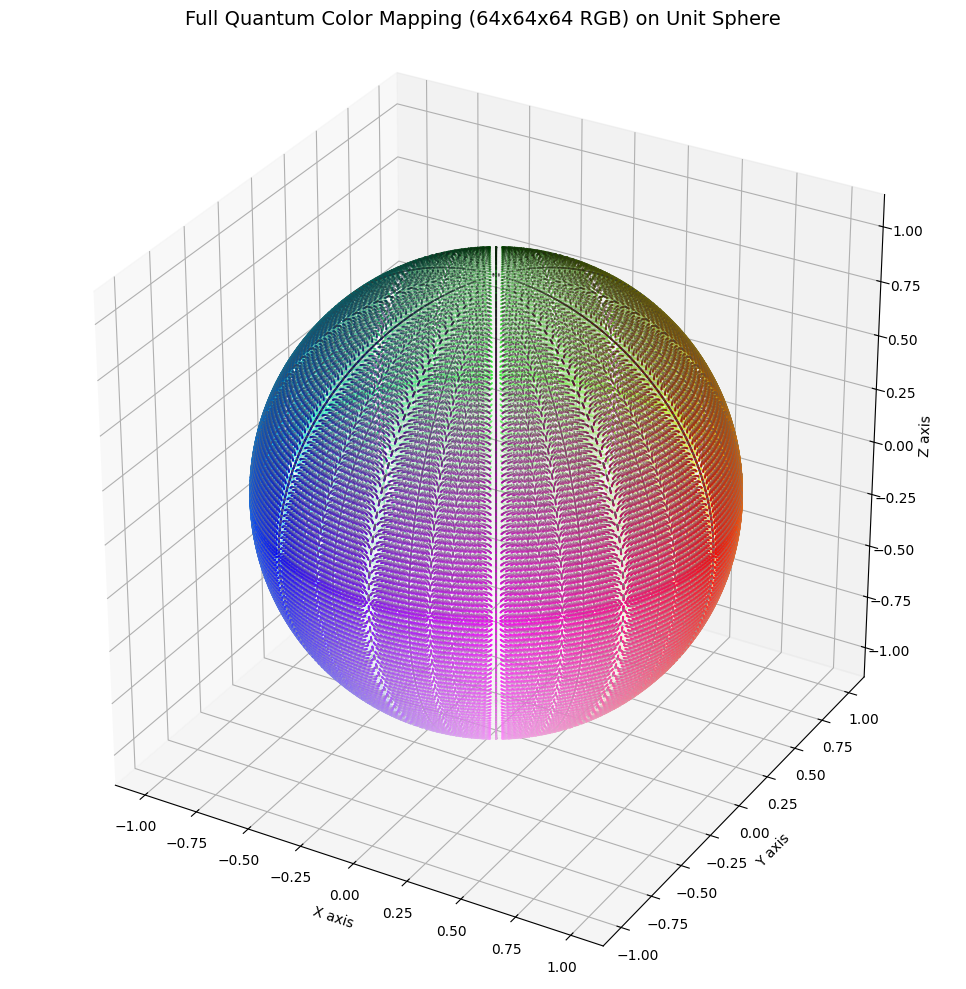

262144

In [2]:
# θ 계산 함수 (북반구/적도/남반구 식 적용)
def compute_theta(r, g, b):
    n = min(r, g, b)
    m = max(r, g, b)
    l = m + n

    if l < 63:  # 북반구
        a = 63 - l
        max_i = int(np.floor((63 - a) / 2))
        for i in range(max_i + 1):
            if m == 63 - a - i and n == i:
                return ((63 - a) * np.pi / 126) + (np.pi / 252) - ((np.pi / 126) * (i + 1) / (max_i + 1))

    elif l == 63:  # 적도
        max_i = int(np.floor(63 / 2))
        for i in range(max_i + 1):
            if m == 63 - i and n == i:
                return (63 * np.pi / 126) + ((-1) ** i) * (np.pi / 252) * i / max_i

    elif l > 63:  # 남반구
        a = l - 63
        max_i = int(np.floor((63 - a) / 2))
        for i in range(max_i + 1):
            if m == 63 - i and n == a + i:
                return ((63 + a) * np.pi / 126) - (np.pi / 252) + ((np.pi / 126) * (i + 1) / (max_i + 1))

    return l * np.pi / 126  # fallback

# RGB → θ, ϕ 변환
def rgb_to_theta_phi(r, g, b):
    n = min(r, g, b)
    m = max(r, g, b)
    l = m + n
    i = (r + g + b) - n - m

    theta = compute_theta(r, g, b)

    if m == n:
        phi = 0
    else:
        if r == m and b == n:
            k = i - b
            phi = (np.pi / 3) * k / (m - n)
        elif g == m and b == n:
            k = g - i
            phi = (np.pi / 3) * k / (m - n) + (np.pi / 3)
        elif g == m and r == n:
            k = i - r
            phi = (np.pi / 3) * k / (m - n) + (2 * np.pi / 3)
        elif b == m and r == n:
            k = b - i
            phi = (np.pi / 3) * k / (m - n) + (3 * np.pi / 3)
        elif b == m and g == n:
            k = i - g
            phi = (np.pi / 3) * k / (m - n) + (4 * np.pi / 3)
        elif r == m and g == n:
            k = r - i
            phi = (np.pi / 3) * k / (m - n) + (5 * np.pi / 3)
        else:
            phi = 0
    return theta, phi

# θ, ϕ → (x, y, z)
def theta_phi_to_xyz(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return x, y, z

# 전체 RGB 매핑
def map_full_rgb():
    coords = []
    colors = []

    for r in range(64):
        for g in range(64):
            for b in range(64):
                theta, phi = rgb_to_theta_phi(r, g, b)
                x, y, z = theta_phi_to_xyz(theta, phi)
                coords.append((x, y, z))
                colors.append((r / 63, g / 63, b / 63))
    return np.array(coords), np.array(colors)

# 3D 시각화
def plot_full_quantum_color_sphere():
    coords, colors = map_full_rgb()
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=colors, s=0.1)
    ax.set_title('Full Quantum Color Mapping (64x64x64 RGB) on Unit Sphere', fontsize=14)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_box_aspect([1, 1, 1])

    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(xs, ys, zs, color='lightgray', linewidth=0.2, alpha=0.2)

    plt.tight_layout()
    plt.show()
    return len(colors)

# 실행
total_colors = plot_full_quantum_color_sphere()
total_colors


In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
import numpy as np

def animate_rotation_and_save(coords, colors, filename="rotation.mp4", fps=30, save_as_gif=False):
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scat = ax.scatter(x, y, z, c=colors, s=0.1)

    ax.set_box_aspect([1, 1, 1])
    ax.set_axis_off()

    def update(frame):
        ax.view_init(elev=20, azim=frame)
        return scat,

    ani = FuncAnimation(fig, update, frames=360, interval=1000 // fps, blit=False)

    if save_as_gif:
        ani.save(filename.replace(".mp4", ".gif"), writer=PillowWriter(fps=fps))
    else:
        ani.save(filename, writer=FFMpegWriter(fps=fps))

    plt.close(fig)


In [5]:
coords, colors = map_full_rgb()
animate_rotation_and_save(coords, colors, filename="color_sphere.gif", fps=15, save_as_gif=True)

In [3]:
import numpy as np
from collections import defaultdict

def find_duplicate_theta_phi():
    coord_map = defaultdict(list)

    for r in range(64):
        for g in range(64):
            for b in range(64):
                theta, phi = rgb_to_theta_phi(r, g, b)
                
                # 소수점 오차 방지를 위한 정밀도 조절 (5자리 정도)
                key = (round(theta, 5), round(phi, 5))
                coord_map[key].append((r, g, b))

    # 중복된 (theta, phi)를 가진 RGB 쌍 추출
    duplicates = {k: v for k, v in coord_map.items() if len(v) > 1}
    return duplicates


find_duplicate_theta_phi()

{}

In [ ]:
import pandas as pd
import numpy as np

PI = np.pi

def get_theta_bounds(r, g, b, theta):
    n = min(r, g, b)
    m = max(r, g, b)
    l = m + n

    # case 1: (0,0,0)
    if (r, g, b) == (0, 0, 0):
        return 0, PI / 504

    # case 12: (63, 63, 63)
    if (r, g, b) == (63, 63, 63):
        return 503 * PI / 504, PI

    # 북반구
    if 0 < l < 63:
        a = 63 - l
        max_i = int(np.floor((63 - a) / 2))
        i = n  # since n = i
        if i < max_i:
            delta_theta = PI / 252 / (max_i + 1)
            return theta - delta_theta, theta + delta_theta
        elif i == max_i:
            max_i_1 = int(np.floor((63 - a - 1) / 2))
            delta_theta_left = PI / 252 / (max_i_1 + 1)
            delta_theta_right = PI / 252 / (max_i + 1)
            return theta - delta_theta_left, theta + delta_theta_right

    # 적도
    elif l == 63:
        i = n
        if i % 2 == 1:  # odd
            delta_theta = PI / 252 / 31
            return theta - delta_theta, theta + delta_theta
        elif i == 30:
            delta_theta = PI / 252 / 31
            return theta - delta_theta, theta + delta_theta
        elif i == 31:
            return theta - PI / 126 / 64, theta + PI / 252 / 31
        else:  # even
            delta_theta = PI / 252 / 31
            return theta - delta_theta, theta + delta_theta

    # 남반구
    elif 63 < l < 127:
        a = l - 63
        max_i = int(np.floor((63 - a) / 2))
        i = n - a
        if i < max_i:
            delta_theta = PI / 252 / (max_i + 1)
            return theta - delta_theta, theta + delta_theta
        elif i == max_i:
            max_i_1 = int(np.floor((63 - a - 1) / 2))
            delta_theta_left = PI / 252 / (max_i + 1)
            delta_theta_right = PI / 252 / (max_i_1 + 1)
            return theta - delta_theta_left, theta + delta_theta_right

    # fallback (일반 균등 구간)
    return theta - PI / 252, theta + PI / 252

def get_phi_bounds(r, g, b, phi):
    n = min(r, g, b)
    m = max(r, g, b)
    l = m + n

    # case 1: (0,0,0)
    if (r, g, b) == (0, 0, 0):
        return 0, 2 * PI

    # case 12: (63,63,63)
    if (r, g, b) == (63, 63, 63):
        return 0, 2 * PI

    if m == n:
        return 0, 2 * PI

    delta_phi = PI / 6 / (m - n)

    # case 4: m=63, n=0
    if m == 63 and n == 0:
        delta_phi = PI / 6 / 63
        return phi - delta_phi, phi + delta_phi

    # case 5: m=62, n=1
    if m == 62 and n == 1:
        delta_phi = PI / 6 / 61
        return phi - delta_phi, phi + delta_phi

    # case 6: l=63, n is odd (2k+1), k=1~14
    if l == 63 and n % 2 == 1 and 1 <= n <= 29:
        return phi - delta_phi, phi + delta_phi

    # case 7: l=63, n is even (2k), k=1~14
    if l == 63 and n % 2 == 0 and 2 <= n <= 28:
        return phi - delta_phi, phi + delta_phi

    # case 8: l=63, n == 30
    if l == 63 and n == 30:
        return phi - delta_phi, phi + delta_phi

    # case 9: l=63, n == 31
    if l == 63 and n == 31:
        return phi - delta_phi, phi + delta_phi

    # case 2: l = 63 - a, 1 ≤ a ≤ 62, n = i < floor((63-a)/2)
    if l < 63:
        a = 63 - l
        max_i = int(np.floor((63 - a) / 2))
        if n < max_i:
            return phi - delta_phi, phi + delta_phi
        elif n == max_i:
            return phi - delta_phi, phi + delta_phi if m > n else (0, 2 * PI)

    # case 10: l = 63 + a, 1 ≤ a ≤ 62, n = i < floor((63-a)/2)
    if l > 63:
        a = l - 63
        max_i = int(np.floor((63 - a) / 2))
        if n - a < max_i:
            return phi - delta_phi, phi + delta_phi
        elif n - a == max_i and m > n:
            return phi - delta_phi, phi + delta_phi

    # fallback
    return phi - delta_phi, phi + delta_phi


def compute_bounds(r, g, b):
    # θ, ϕ 계산
    theta, phi = rgb_to_theta_phi(r, g, b)

    # θ bound
    theta_start, theta_end = get_theta_bounds(r, g, b, theta)

    # ϕ bound
    phi_start, phi_end = get_phi_bounds(r, g, b, phi)

    return theta_start, theta, theta_end, phi_start, phi, phi_end

def generate_lut_with_bounds():
    records = []
    for r in range(64):
        for g in range(64):
            for b in range(64):
                theta_start, theta, theta_end, phi_start, phi, phi_end = compute_bounds(r, g, b)
                records.append({
                    'r': r,
                    'g': g,
                    'b': b,
                    'theta_start': theta_start,
                    'theta': theta,
                    'theta_end': theta_end,
                    'phi_start': phi_start,
                    'phi': phi,
                    'phi_end': phi_end
                })

    df = pd.DataFrame(records)
    df.to_csv("LUT_theta_phi_bounds.csv", index=False)


In [32]:
generate_lut_with_bounds()

In [75]:
import pandas as pd

def find_matching_rgb(theta_prime, phi_prime, lut_path="LUT_theta_phi_bounds.csv"):
    # 엑셀 로드
    df = pd.read_csv(lut_path)

    # 1차 필터링: θ 범위 내에 있는 행 추출
    theta_filtered = df[(df['theta_start'] <= theta_prime) & (df['theta_end'] >= theta_prime)]

    # 2차 필터링: ϕ 범위 내에 있는 행 추출
    phi_filtered = theta_filtered[(theta_filtered['phi_start'] <= phi_prime) & (theta_filtered['phi_end'] >= phi_prime)]

    return phi_filtered[['r', 'g', 'b', 'theta_start', 'theta', 'theta_end', 'phi_start', 'phi', 'phi_end']]


In [ ]:
theta_prime = np.random.uniform(0, np.pi)
phi_prime = np.random.uniform(0, 2 * np.pi)
print("theta prime = ", theta_prime, "phi prime = ",phi_prime)
find_matching_rgb(theta_prime, phi_prime, lut_path="LUT_theta_phi_bounds.csv")

theta prime =  1.6766344245557676 phi prime =  4.272894725837693


,r,g,b,theta_start,theta,theta_end,phi_start,phi,phi_end
108138,26,25,42,1.675932,1.676347,1.676763,4.21959,4.25039,4.28119


# Test

In [73]:
# RGB = (20,30,40) 
# theta = 1.49157285613985, phi = 3.66519142918809
theta = 1.49157285613985
phi = 3.66519142918809
start = time.time()


phis = []

for i in range(1):
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(1):
    thetas.append(theta)

w_bits = int(np.ceil(1))
h_bits = int(np.ceil(1))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(2, 'q1')
c = QuantumRegister(1,'q0')
p = QuantumRegister(1, 'q2')
cr = ClassicalRegister(O.size+c.size+p.size, "cl")

qc_image = QuantumCircuit(c,O,p, cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)

qc_image.barrier()
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind): 
            qc_image.barrier()
            qc_image.x(O[k])
            

    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()

        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0],)

            qc_image.barrier()
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           

qc_image.x(p)
qc_image.x(O)
statevec_qc = Statevector(qc_image)
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
result = aer_sim.run(t_qc_image, shots=100000).result()
counts = result.get_counts()

pixel_theta_recon = []
pixel_phi_recon = []

pixel_theta = []
pixel_phi = []

for i in range(2):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        decision = int(key[-1])
        bin_coord = key[1:-1]
        int_coord = int(bin_coord, 2)
        if int_coord == i and decision == 1:
            pixel_theta.append((state,bin_coord, amount))
        elif int_coord == i and decision == 0:
            pixel_phi.append((state,bin_coord, amount))

# ======================== phi ====================================
phi_result_dict = {}
for state in pixel_phi:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict:
        phi_result_dict[key] += value  
    else:
        phi_result_dict[key] = value  

phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
#print(phi_result_list)

phi_state_0 = []
for state, phi, amount in pixel_phi:
    if not int(state):
        phi_state_0.append((phi, amount))

for i in range(2):
    try:
        phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
        pixel_phi_recon.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict = {}
for state in pixel_theta:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict:
        theta_result_dict[key] += value  
    else:
        theta_result_dict[key] = value  

theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

theta_state_0 = []

for state, theta, amount in pixel_theta:
    if not int(state):
        theta_state_0.append((theta, amount))

for i in range(2):
    try:
        theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
        pixel_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

print(pixel_theta_recon, pixel_phi_recon)
print(thetas[0]*2, phis[0]*4)

theta_prime = pixel_theta_recon[0]*0.5
phi_prime = pixel_phi_recon[0]
find_matching_rgb(theta_prime, phi_prime, lut_path="LUT_theta_phi_bounds.csv")

[2.983224564467907, 0.0] [3.6776276834363673, 0.0]
2.9831457122797 3.6652


,r,g,b,theta_start,theta,theta_end,phi_start,phi,phi_end
83880,20,30,40,1.491171,1.491573,1.491975,3.639011,3.665191,3.691371


In [4]:
import cv2

airplane = cv2.imread("airplane1.png")

# LUT 로드 및 θ, φ 추출
lut_df = pd.read_csv("LUT_theta_phi_bounds.csv")
lut_dict = {(row.r, row.g, row.b): (row.theta, row.phi) for row in lut_df.itertuples()}

def get_theta_phi_from_image_lut(image_rgb_array, lut_dict):
    height, width, _ = image_rgb_array.shape
    theta_map = np.zeros((height, width))
    phi_map = np.zeros((height, width))

    for i in range(height):
        for j in range(width):
            r63, g63, b63 = (image_rgb_array[i, j]/255 * 63).astype(int)
            theta, phi = lut_dict.get((r63, g63, b63), (0, 0))
            theta_map[i, j] = theta
            phi_map[i, j] = phi

    return theta_map, phi_map

theta_map, phi_map = get_theta_phi_from_image_lut(airplane, lut_dict)
theta_map, phi_map


(array([[2.5345633 , 2.51154797, 2.55981624, ..., 2.58474951, 2.58474951,
         2.55981624],
        [2.58267174, 2.58474951, 2.6077939 , ..., 2.63272718, 2.63272718,
         2.6077939 ],
        [2.55981624, 2.58474951, 2.58474951, ..., 2.61006056, 2.61006056,
         2.58474951],
        ...,
        [1.53651307, 1.60507958, 1.67967163, ..., 1.82797844, 1.82797844,
         1.80321007],
        [1.60507958, 1.67967163, 1.77916727, ..., 1.8289019 , 1.80321007,
         1.80321007],
        [1.68050274, 1.7046049 , 1.75435682, ..., 1.80410054, 1.75435682,
         1.72942354]]),
 array([[0.33319922, 0.3989324 , 0.34906585, ..., 0.41887902, 0.36651914,
         0.3989324 ],
        [0.33319922, 0.36651914, 0.3989324 , ..., 0.41887902, 0.36651914,
         0.3989324 ],
        [0.3989324 , 0.36651914, 0.36651914, ..., 0.44092529, 0.38580962,
         0.41887902],
        ...,
        [3.66519143, 3.66519143, 3.60701379, ..., 3.61759154, 3.61759154,
         3.56047167],
        [3.6

In [48]:
theta_map_flat = theta_map.flatten()
phi_map_flat = phi_map.flatten()

In [64]:
for i in range(5):
    print((airplane[0][i] /255 * 63).astype(int))
    print(find_matching_rgb(theta_map_flat[i], phi_map_flat[i], lut_path="LUT_theta_phi_bounds.csv"))
    print("===================================================================")

[62 47 40]
         r   g   b  theta_start     theta  theta_end  phi_start       phi  \
257000  62  47  40     2.533604  2.534563   2.535522   0.309399  0.333199   

         phi_end  
257000  0.356999  
[61 48 40]
         r   g   b  theta_start     theta  theta_end  phi_start       phi  \
252968  61  48  40     2.510589  2.511548   2.512507   0.373999  0.398932   

         phi_end  
252968  0.423866  
[62 48 41]
         r   g   b  theta_start     theta  theta_end  phi_start       phi  \
257065  62  48  41     2.558777  2.559816   2.560855   0.324133  0.349066   

         phi_end  
257065  0.373999  
[62 49 41]
         r   g   b  theta_start     theta  theta_end  phi_start       phi  \
257129  62  49  41     2.558777  2.559816   2.560855   0.373999  0.398932   

         phi_end  
257129  0.423866  
[62 50 42]
         r   g   b  theta_start    theta  theta_end  phi_start       phi  \
257194  62  50  42     2.583711  2.58475   2.585788   0.392699  0.418879   

         phi_end  
2

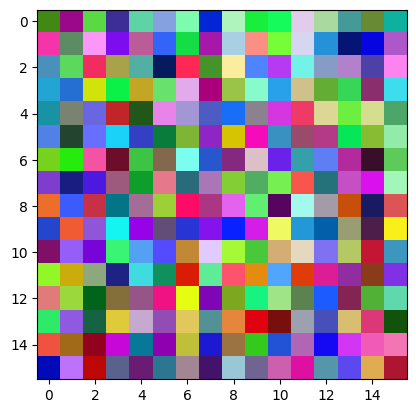

In [16]:
image = np.random.randint(0, 256, size=(16, 16, 3), dtype=np.uint8)

plt.imshow(image, cmap = 'gray')

In [17]:
radius = []
k_list = []
size_list = []
def project(img, n):
    global radius
    (row, col, _) = img
    x = row
    y = col
    z = 0
    r = round(np.sqrt(2**(2*n)/(8 * np.pi)),4)
    radius.append(r)
    Q = np.array([x, y, z], dtype=np.float32)
    X = get_2d_to_3d(Q,r)
    return X

def get_2d_to_3d(point,r):
    global size_list, k_list
    [x, y, _] = point
    k = round(4*r**2 / (x**2 + y**2 + 4*r**2), 4)
    P = np.array([k * x, k * y, (1-2*k)*r ])
    size = np.sqrt(P[0]**2+P[1]**2+P[2]**2)
    resize = P*(1/size)
    k = k * (1/size)
    size_list.append(size)
    k_list.append(k)
    return resize

def generate_coordinates(input_tuple):
    # 입력된 튜플의 값을 2로 나눔
    x, y = input_tuple
    x /= 2
    y /= 2

    # 좌표 리스트 초기화
    coordinates = []

    # 음수부터 양수까지 좌표 생성
    for i in range(-int(x), int(x) + 1):
        for j in range(-int(x), int(y) + 1):
            if i != 0 and j != 0:
                # z 값은 항상 0
                coordinates.append(np.array([i, j, 0]))
    return coordinates

def generate_normal_coordinates(input_tuple):
    # 입력된 튜플의 값을 2로 나눔
    x, y = input_tuple
    x /= 2
    y /= 2

    # 좌표 리스트 초기화
    coordinates = []

    # 양수 값 좌표만 생성
    for i in range(0, 2 * int(x) + 1):
        for j in range(0, 2 * int(y) + 1):
            if i != 0 and j != 0:
                # z 값은 항상 0
                coordinates.append(np.array([i, j, 0]))
    return coordinates

def y_axis_reflection(point):
    return np.array([-point[0], point[1], point[2]])

def x_axis_reflection(point):
    return np.array([point[0], -point[1], point[2]])

def origin_reflection(point):
    return np.array([-point[0], -point[1], point[2]])


[array([0.36209507, 0.37666806, 0.85264783]), array([0.39441159, 0.35335757, 0.84827939]), array([0.4190923 , 0.35229295, 0.83681021]), array([0.44145536, 0.3531352 , 0.82487132]), array([0.45806522, 0.3447501 , 0.81934341]), array([0.49957043, 0.32885811, 0.80142481]), array([0.5142357 , 0.33740473, 0.78849204]), array([0.54196988, 0.311508  , 0.78053277]), array([0.57618731, 0.28942032, 0.7643586 ]), array([0.59642402, 0.24025723, 0.76586869]), array([0.60939093, 0.23511529, 0.7572077 ]), array([0.63305057, 0.19706642, 0.74860657]), array([0.65534734, 0.15347118, 0.73957181]), array([0.66887714, 0.12098645, 0.73346142]), array([0.67319058, 0.08878538, 0.73411961]), array([0.69857214, 0.03882453, 0.71448557]), array([0.36969177, 0.39601268, 0.8405367 ]), array([0.39751612, 0.38347409, 0.83362375]), array([0.41625159, 0.38574871, 0.82336659]), array([0.43509691, 0.38626673, 0.81331955]), array([0.47270488, 0.37129851, 0.79917928]), array([0.50119993, 0.37746071, 0.77866684]), array([0.

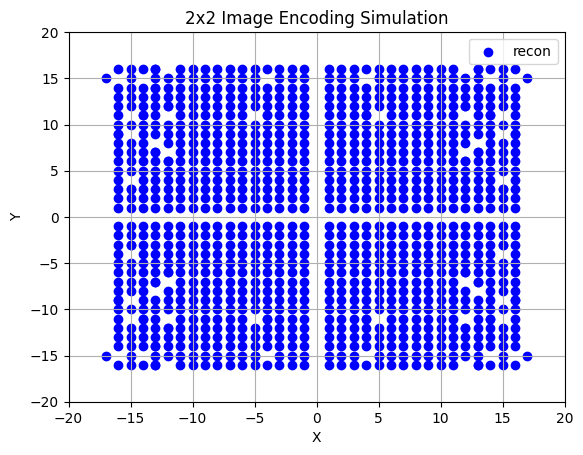

0.046875


In [18]:
start = time.time()

img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(w_bits+h_bits, 'q1')
c = QuantumRegister(1,'q0')
p = QuantumRegister(1, 'q2')
cr = ClassicalRegister(O.size+c.size+p.size, "cl")

qc_image = QuantumCircuit(c,O,p, cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)

qc_image.barrier()
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind): 
            qc_image.barrier()
            qc_image.x(O[k])
            

    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()

        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0],)

            qc_image.barrier()
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           

qc_image.x(p)
qc_image.x(O)
statevec_qc = Statevector(qc_image)
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
result = aer_sim.run(t_qc_image, shots=8000000).result()
counts = result.get_counts()

pixel_theta_recon = []
pixel_phi_recon = []

pixel_theta = []
pixel_phi = []

for i in range(0, len(P)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        decision = int(key[-1])
        bin_coord = key[1:-1]
        int_coord = int(bin_coord, 2)
        if int_coord == i and decision == 1:
            pixel_theta.append((state,bin_coord, amount))
        elif int_coord == i and decision == 0:
            pixel_phi.append((state,bin_coord, amount))

# ======================== phi ====================================
phi_result_dict = {}
for state in pixel_phi:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict:
        phi_result_dict[key] += value  
    else:
        phi_result_dict[key] = value  

phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
#print(phi_result_list)

phi_state_0 = []
for state, phi, amount in pixel_phi:
    if not int(state):
        phi_state_0.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
        pixel_phi_recon.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict = {}
for state in pixel_theta:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict:
        theta_result_dict[key] += value  
    else:
        theta_result_dict[key] = value  

theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

theta_state_0 = []

for state, theta, amount in pixel_theta:
    if not int(state):
        theta_state_0.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
        pixel_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_pixel = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    y = np.sin(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    z = np.cos(pixel_theta_recon[i])
    recon_pixel.append(np.array([x,y,z]))
print(recon_pixel)
back_recon_pixel= []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = np.round(recon_pixel[i][0] / k)
    Y = np.round(recon_pixel[i][1] / k)
    back_P = np.array([X,Y,0])
    back_recon_pixel.append(back_P)
back_recon_pixel = list(reversed(back_recon_pixel))
print("reconstructed pixel  =",back_recon_pixel)
end = time.time()
print(f"{end - start:.5f} sec")

back_2 = [y_axis_reflection(point) for point in back_recon_pixel]
back_3 = [origin_reflection(point) for point in back_recon_pixel]
back_4 = [x_axis_reflection(point) for point in back_recon_pixel]

x_values = [point[0] for point in back_recon_pixel]
y_values = [point[1] for point in back_recon_pixel]

x_2 = [point[0] for point in back_2]
y_2 = [point[1] for point in back_2]

x_3 = [point[0] for point in back_3]
y_3 = [point[1] for point in back_3]

x_4 = [point[0] for point in back_4]
y_4 = [point[1] for point in back_4]

x_Q = [point[0] for point in Q]
y_Q = [point[1] for point in Q]


origin_image = np.random.uniform(low=0,high=255, size=(2**(n+1),2**(n+1),3)).astype(int)

origin_img_mean  = np.mean(origin_image, axis=2, dtype=np.uint8)
origin_input_tuple = origin_img_mean.shape
Q_origin = generate_coordinates(origin_input_tuple)

x_Q_origin = [point[0] for point in Q_origin]
y_Q_origin = [point[1] for point in Q_origin]

# 시각화
plt.scatter(x_values, y_values, color='blue', label='recon')
plt.scatter(x_2, y_2, color='blue')
plt.scatter(x_3, y_3, color='blue')
plt.scatter(x_4, y_4, color='blue')
#plt.scatter(x_Q_origin, y_Q_origin, color='gray', label = 'classical')
plt.title('2x2 Image Encoding Simulation')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.legend()
plt.grid(True)
plt.show()

error = []
for i in range(len(Q)):
    del_x = x_Q[i] - x_values[i]
    del_y = y_Q[i] - y_values[i]
    err = del_x**2+del_y**2
    error.append(err)

MSE = sum(error)/len(Q) 
print(MSE)

In [19]:
position = back_2  + back_recon_pixel + back_3 + back_4
# (1) 앞 2개 값만 추출
xy = np.round(np.array([arr[:2] for arr in position])).astype(int)  # shape (N, 2)

# (2) 정렬: y 내림차순, x 오름차순
sorted_indices = np.lexsort((xy[:, 0], -xy[:, 1]))  # x 오름차순, y 내림차순

# (3) 정렬된 좌표
xy_sorted = xy[sorted_indices]

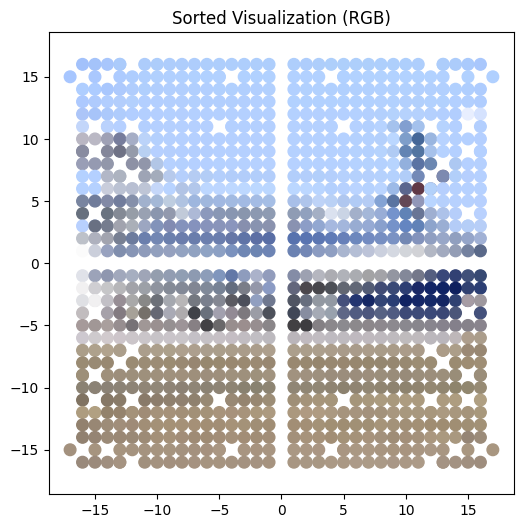

In [45]:
airplane = cv2.imread("airplane1.png")
airplane_rgb = cv2.cvtColor(airplane, cv2.COLOR_BGR2RGB)
airplane_flat = airplane_rgb.flatten()

# airplane_flat shape: (1024, 3) ← RGB 3채널로 reshape 필요
colors = airplane_flat.reshape(-1, 3) / 255  # 정규화 필요

plt.figure(figsize=(6, 6))
scatter = plt.scatter(xy_sorted[:, 0], xy_sorted[:, 1], 
                      c=colors, s=70)
plt.axis('equal')
plt.title('Sorted Visualization (RGB)')
plt.show()


In [46]:
import numpy as np

# (1) 복사본 생성 (수정용)
xy_shifted = xy_sorted.copy()

# (2) x, y 추출
x = xy_shifted[:, 0]
y = xy_shifted[:, 1]

# (3) 사분면별 마스크 정의
mask_q2 = (x < 0) & (y >= 0)
mask_q3 = (x < 0) & (y < 0)
mask_q4 = (x >= 0) & (y < 0)

# (4) 평행이동 적용
xy_shifted[mask_q2, 0] += 1            # Q2: x += 1
xy_shifted[mask_q3, 0] += 1            # Q3: x += 1
xy_shifted[mask_q3, 1] += 1            # Q3: y += 1
xy_shifted[mask_q4, 1] += 1            # Q4: y += 1

# ✅ 결과: xy_shifted에는 이동된 좌표들이 들어있습니다

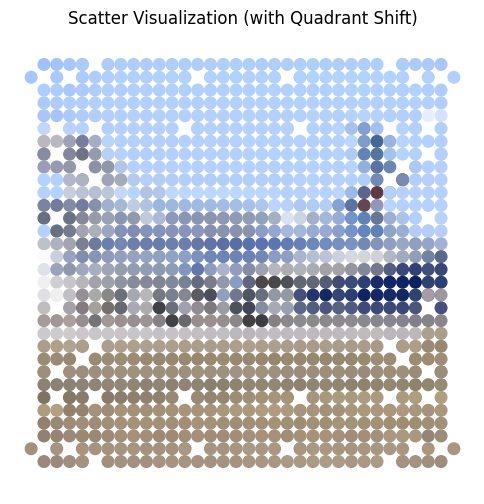

In [50]:
import matplotlib.pyplot as plt

# (1) x, y 좌표와 grayscale 값 준비
x = xy_shifted[:, 0]
y = xy_shifted[:, 1]

colors = airplane_flat.reshape(-1, 3) / 255
# (2) 시각화
plt.figure(figsize=(6, 6))
plt.scatter(x, y, c= colors, s=70)
plt.axis('equal')
plt.axis('off')
plt.title('Scatter Visualization (with Quadrant Shift)')
plt.show()


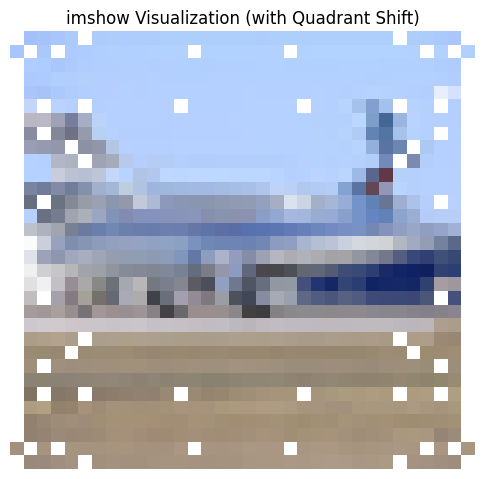

In [61]:
import numpy as np

# (1) 전체 좌표 범위 계산
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

width = x_max - x_min + 1
height = y_max - y_min + 1

# (2) 이미지 초기화 (빈 공간은 NaN)
image = np.full((height, width, 3), np.nan)

# (3) 각 좌표를 이미지 배열에 매핑
for xi, yi, g in zip(x, y, colors):
    col = int(xi - x_min)           # x → column
    row = int(y_max - yi)           # y → row (영상 좌표계: 위가 0)
    image[row, col] = g

# (4) 시각화
plt.figure(figsize=(6, 6))
plt.imshow(image, vmin=0, vmax=255, interpolation='nearest')
plt.axis('off')
plt.title('imshow Visualization (with Quadrant Shift)')
plt.show()

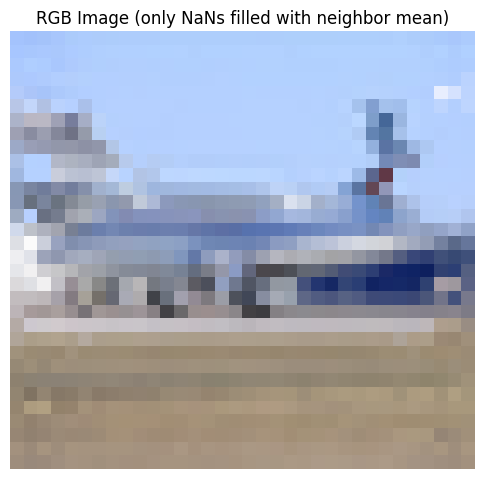

In [62]:
import numpy as np
from scipy.ndimage import generic_filter

def fill_nan_with_neighbor_avg(channel):
    """NaN을 인접 평균으로 대체한 채널 반환"""
    def nanmean_filter(values):
        values = values[~np.isnan(values)]
        return np.mean(values) if values.size > 0 else np.nan

    # 전체 채널에 대해 보간
    interpolated = generic_filter(channel, function=nanmean_filter, size=3, mode='constant', cval=np.nan)
    
    # NaN 위치만 업데이트
    filled = channel.copy()
    mask = np.isnan(channel)
    filled[mask] = interpolated[mask]
    
    return filled

image_filled = np.zeros_like(image)

for c in range(3):  # R, G, B 채널
    image_filled[:, :, c] = fill_nan_with_neighbor_avg(image[:, :, c])


plt.figure(figsize=(6, 6))
plt.imshow(image_filled)
plt.axis('off')
plt.title('RGB Image (only NaNs filled with neighbor mean)')
plt.show()


# Airplane with color space

In [120]:
def fill_missing_theta_for_state_0(pixel_theta):
    # (1) 모든 가능한 theta 10bit 문자열
    all_theta = {format(i, '010b') for i in range(1024)}

    # (2) 기존 pixel_theta 중 state가 '0'인 것만 필터링
    state_0_entries = [(state, theta, amount) for state, theta, amount in pixel_theta if state == '0']

    # (3) 존재하는 theta 추출
    existing_theta_0 = {theta for state, theta, amount in state_0_entries}

    # (4) 누락된 theta 확인
    missing_theta_0 = all_theta - existing_theta_0

    # (5) 누락된 항목을 amount=0으로 추가
    filled_entries = list(pixel_theta)  # 원본 복사

    for theta in missing_theta_0:
        filled_entries.append(('0', theta, 0))

    return filled_entries

def sort_by_theta_bin(filled_pixel_theta):
    return sorted(filled_pixel_theta, key=lambda x: int(x[1], 2))

In [118]:
import cv2

airplane = cv2.imread("airplane1.png")
airplane_rgb = cv2.cvtColor(airplane, cv2.COLOR_BGR2RGB)
# LUT 로드 및 θ, φ 추출
lut_df = pd.read_csv("LUT_theta_phi_bounds.csv")
lut_dict = {(row.r, row.g, row.b): (row.theta, row.phi) for row in lut_df.itertuples()}

def get_theta_phi_from_image_lut(image_rgb_array, lut_dict):
    height, width, _ = image_rgb_array.shape
    theta_map = np.zeros((height, width))
    phi_map = np.zeros((height, width))

    for i in range(height):
        for j in range(width):
            r63, g63, b63 = (image_rgb_array[i, j]/255 * 63).astype(int)
            theta, phi = lut_dict.get((r63, g63, b63), (0, 0))
            theta_map[i, j] = theta
            phi_map[i, j] = phi

    return theta_map, phi_map

theta_map, phi_map = get_theta_phi_from_image_lut(airplane_rgb, lut_dict)
theta_map, phi_map


(array([[2.5345633 , 2.51154797, 2.55981624, ..., 2.58474951, 2.58474951,
         2.55981624],
        [2.58267174, 2.58474951, 2.6077939 , ..., 2.63272718, 2.63272718,
         2.6077939 ],
        [2.55981624, 2.58474951, 2.58474951, ..., 2.61006056, 2.61006056,
         2.58474951],
        ...,
        [1.53651307, 1.60507958, 1.67967163, ..., 1.82797844, 1.82797844,
         1.80321007],
        [1.60507958, 1.67967163, 1.77916727, ..., 1.8289019 , 1.80321007,
         1.80321007],
        [1.68050274, 1.7046049 , 1.75435682, ..., 1.80410054, 1.75435682,
         1.72942354]]),
 array([[3.85559098, 3.7898578 , 3.83972435, ..., 3.76991118, 3.82227106,
         3.7898578 ],
        [3.85559098, 3.82227106, 3.7898578 , ..., 3.76991118, 3.82227106,
         3.7898578 ],
        [3.7898578 , 3.82227106, 3.82227106, ..., 3.74786492, 3.80298058,
         3.76991118],
        ...,
        [0.52359878, 0.52359878, 0.58177642, ..., 0.57119866, 0.57119866,
         0.62831853],
        [0.5

In [141]:
w_bits = int(np.ceil(math.log(airplane.shape[1],2)))
h_bits = int(np.ceil(math.log(airplane.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(w_bits+h_bits, 'q1')
c = QuantumRegister(1,'q0')
p = QuantumRegister(1, 'q2')
cr = ClassicalRegister(O.size+c.size+p.size, "cl")

qc_image = QuantumCircuit(c,O,p, cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)

qc_image.barrier()
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

theta_flat = theta_map.flatten()
phi_flat = phi_map.flatten()

thetas = theta_flat * 0.5
phis = phi_flat * 0.25

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind): 
            qc_image.barrier()
            qc_image.x(O[k])
            

    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()

        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0],)

            qc_image.barrier()
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           

qc_image.x(p)
qc_image.x(O)
statevec_qc = Statevector(qc_image)
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
result = aer_sim.run(t_qc_image, shots=8000000).result()
counts = result.get_counts()

In [147]:
pixel_theta_recon = []
pixel_phi_recon = []

pixel_theta = []
pixel_phi = []

for i in range(0, len(thetas)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        decision = int(key[-1])
        bin_coord = key[1:-1]
        int_coord = int(bin_coord, 2)
        if int_coord == i and decision == 1:
            pixel_theta.append((state,bin_coord, amount))
        elif int_coord == i and decision == 0:
            pixel_phi.append((state,bin_coord, amount))

# ======================== phi ====================================
phi_result_dict = {}
for state in pixel_phi:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict:
        phi_result_dict[key] += value  
    else:
        phi_result_dict[key] = value  

phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
#print(phi_result_list)

phi_state_0 = []

for state, theta, amount in sort_by_theta_bin(fill_missing_theta_for_state_0(pixel_phi)):
    if not int(state):
        phi_state_0.append((phi, amount))

for i in range(0, len(thetas)):
    try:
        phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
        pixel_phi_recon.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict = {}
for state in pixel_theta:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict:
        theta_result_dict[key] += value  
    else:
        theta_result_dict[key] = value  

theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

theta_state_0 = []

for state, theta, amount in sort_by_theta_bin(fill_missing_theta_for_state_0(pixel_theta)):
    if not int(state):
        theta_state_0.append((theta, amount))

for i in range(0, len(thetas)):
    try:
        theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
        pixel_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

In [198]:
error_theta = []
error_phi = []

recon_theta = list(reversed(pixel_theta_recon))
recon_phi = list(reversed(pixel_phi_recon))

for i in range(len(thetas)):
    err = (recon_theta[i] - thetas[i])**2
    error_theta.append(err)

MSE = sum(error_theta)/len(thetas) 
print(MSE)

print("======================================")

for i in range(len(phis)):
    err = (recon_phi[i] - phis[i])**2
    error_phi.append(err)

MSE = sum(error_phi)/len(phis) 
print(MSE)

1.127442330000018
6.03047586555002


In [ ]:
from tqdm import tqdm

def load_lut_dataframe(lut_path="LUT_theta_phi_bounds.csv"):
    df = pd.read_csv(lut_path)
    return df

def match_all_theta_phi(recon_theta, recon_phi, lut_df):
    matched_rgbs = []

    for t, p in tqdm(zip(recon_theta, recon_phi), total=len(recon_theta)):
        match = lut_df[
            (lut_df['theta_start'] <= t) & (lut_df['theta_end'] >= t) &
            (lut_df['phi_start'] <= p) & (lut_df['phi_end'] >= p)
        ]
        if not match.empty:
            rgb = match.iloc[0][['r', 'g', 'b']].values # 첫 번째 일치 항목 사용
        else:
            rgb = [0, 0, 0]  # fallback
        matched_rgbs.append(rgb)

    return np.array(matched_rgbs, dtype=np.uint8)

def reshape_and_visualize(rgb_array, height=32, width=32):
    rgb_image = rgb_array.reshape((height, width, 3))
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.title("Reconstructed RGB Image")
    plt.show()
    return rgb_image


100%|██████████| 1024/1024 [00:01<00:00, 580.74it/s]


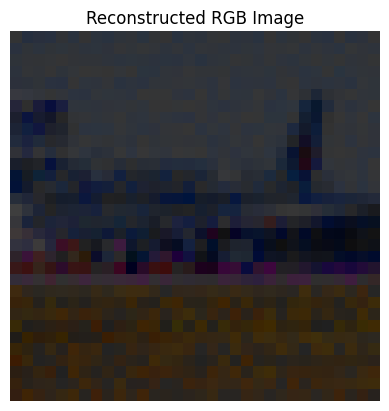

In [195]:
# recon_theta, recon_phi: shape = (1024,)
lut_df = load_lut_dataframe("LUT_theta_phi_bounds.csv")
matched_rgb = match_all_theta_phi(recon_theta, recon_phi, lut_df)
rgb_image = reshape_and_visualize(matched_rgb)

In [225]:
airplane = cv2.imread("airplane1.png")
airplane_rgb = cv2.cvtColor(airplane, cv2.COLOR_BGR2RGB)
airplane_flat = airplane_rgb.flatten()
airplane_flat_norm = np.round(airplane_flat * 0.25)
airplane_norm_reshape = airplane_flat_norm.reshape((-1,3))
airplane_norm_reshape_final = np.array(airplane_norm_reshape, dtype=np.uint8)

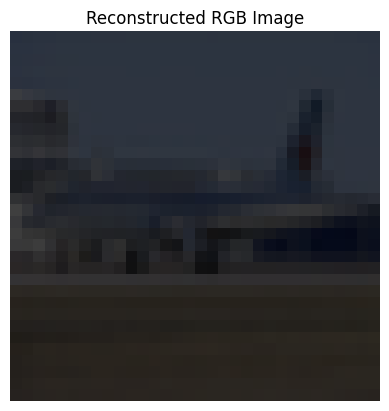

In [227]:
rgb_image = reshape_and_visualize(airplane_norm_reshape_final)